In [ ]:
# [13]
# Core libraries
import os
import cv2
import numpy as np

# Machine Learning Libraries
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import joblib # To save the model
import matplotlib.pyplot as plt
import seaborn as sns

# [14] Connect Google Drive (Optional for Colab)
from google.colab import drive
drive.mount('/content/drive')

# [15] Configure Path and SIFT/K-Means parameters
# Modify the path to match the location of your dataset folder 'Road_Detection_Data' inside 'My Drive'
DATASET_PATH = 'dataset/cropped_objectsV3'
SPLITS = ['train', 'valid', 'test']

# Initialize SIFT Detector
sift = cv2.SIFT_create()

# Define the size of the Visual Vocabulary (K in K-Means)
NUM_VISUAL_WORDS = 100

print("Libraries and paths initialized successfully.")
print(f"Dataset path is: {DATASET_PATH}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Libraries and paths initialized successfully.
Dataset path is: dataset/cropped_objectsV3


In [ ]:
import zipfile



with zipfile.ZipFile("cropped_objectsV3-20251208T100332Z-1-001 (1).zip", 'r') as zip_ref:
    zip_ref.extractall('dataset')

FileNotFoundError: [Errno 2] No such file or directory: 'cropped_objectsV3-20251208T100332Z-1-001 (1).zip'

In [ ]:
print("--- 2.1: Extracting SIFT Descriptors: Collect All Descriptors ---")
all_descriptors = []
image_data = [] # To store (filepath, label_id)
label_map = {}  # e.g.: {'Road': 0}
current_label_id = 0

for split in SPLITS:
    split_path = os.path.join(DATASET_PATH, split)
    if not os.path.exists(split_path):
        continue

    for object_name in os.listdir(split_path):
        object_path = os.path.join(split_path, object_name)
        if os.path.isdir(object_path):
            # 1. Assign digital label
            if object_name not in label_map:
                label_map[object_name] = current_label_id
                current_label_id += 1
            label_id = label_map[object_name]

            for filename in os.listdir(object_path):
                if filename.endswith(('.jpg', '.jpeg', '.png')):
                    filepath = os.path.join(object_path, filename)
                    image_data.append((filepath, label_id)) # Store image data

                    # 2. Read image in Grayscale
                    img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
                    if img is None: continue

                    # 3. Extract SIFT features
                    kp, des = sift.detectAndCompute(img, None)

                    if des is not None:
                        all_descriptors.append(des) # Aggregate descriptors

# Concatenate all descriptors
if all_descriptors:
    all_descriptors = np.concatenate(all_descriptors, axis=0).astype(np.float32)
    print(f"Total SIFT descriptors collected: {len(all_descriptors)}")
else:
    print("Error: No descriptors found. Check path validity and image presence.")

--- 2.1: Extracting SIFT Descriptors: Collect All Descriptors ---
Total SIFT descriptors collected: 107175


In [ ]:
print("--- 2.2: Building Visual Vocabulary using K-Means ---")

# Setup K-Means criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
flags = cv2.KMEANS_RANDOM_CENTERS

# Apply K-Means clustering
compactness, labels, visual_vocabulary = cv2.kmeans(
    all_descriptors,
    NUM_VISUAL_WORDS,
    None,
    criteria,
    10,
    flags
)

print(f"Visual vocabulary built. Shape: {visual_vocabulary.shape}")

--- 2.2: Building Visual Vocabulary using K-Means ---
Visual vocabulary built. Shape: (100, 128)


In [ ]:
print("--- 2.3: Creating BoVW Feature Vectors ---")
X = [] # Final feature matrix (BoVW histograms)
y = [] # Labels vector

for filepath, label_id in image_data:
    # 1. Read image and extract descriptors
    img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    if img is None: continue

    kp, des = sift.detectAndCompute(img, None)

    if des is not None:
        # 2. Initialize BoVW Histogram
        histogram = np.zeros(visual_vocabulary.shape[0]) # Size = NUM_VISUAL_WORDS (100)

        # 3. Assign each descriptor to the closest visual word (Cluster)
        for descriptor in des:
            descriptor = descriptor.reshape(1, -1)

            # Calculate distances to all visual words
            distances = np.sqrt(np.sum((visual_vocabulary - descriptor)**2, axis=1))

            # Find the closest word
            closest_visual_word_index = np.argmin(distances)

            # Increment the word count in the histogram
            histogram[closest_visual_word_index] += 1

        # 4. Normalize the histogram
        if np.sum(histogram) > 0:
            histogram = histogram / np.sum(histogram) # Normalize so the sum is 1

        X.append(histogram)
        y.append(label_id)

X = np.array(X)
y = np.array(y)
print(f"Final feature matrix (Images x Words) shape: {X.shape}")

--- 2.3: Creating BoVW Feature Vectors ---
Final feature matrix (Images x Words) shape: (3019, 100)


In [ ]:
# Create a reverse label map for printing class names
class_names = {v: k for k, v in label_map.items()}

# Split Data: 80% Training, 20% Testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training data size (images): {X_train.shape[0]}")

print("--- 3.2: Training Random Forest Classifier ---")

# Number of decision trees in the forest (more is generally better but slower)
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# Start Training
rf_classifier.fit(X_train, y_train)

print("Random Forest training complete.")

Training data size (images): 2415
--- 3.2: Training Random Forest Classifier ---
Random Forest training complete.


# hyperamters

In [ ]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier


rf = RandomForestClassifier(random_state=42)


param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 0.5]
}


grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)


print("Starting Grid Search...")
grid_search.fit(X_train, y_train)



print("-" * 30)
print(f"Best Cross-Validation Score: {grid_search.best_score_:.4f}")
print("Best Hyperparameters Found:")
print(grid_search.best_params_)
print("-" * 30)


best_rf_model = grid_search.best_estimator_


Starting Grid Search...
Fitting 5 folds for each of 54 candidates, totalling 270 fits
------------------------------
Best Cross-Validation Score: 0.6501
Best Hyperparameters Found:
{'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 200}
------------------------------


In [ ]:
# Number of decision trees in the forest (Tuned Hyperparameters)
rf_classifier = RandomForestClassifier(n_estimators=200, max_depth=15, min_samples_leaf=4, max_features='sqrt', random_state=42, n_jobs=-1)

# Start Training
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(max_depth=15, min_samples_leaf=4, n_estimators=200,
                       n_jobs=-1, random_state=42)


Model Accuracy: 65.89%

--- Detailed Classification Report ---
                precision    recall  f1-score   support

         buses       0.00      0.00      0.00        22
      bicycles       0.00      0.00      0.00        16
traffic lights       0.74      0.78      0.76       188
   motorcycles       1.00      0.02      0.04        48
 fire hydrants       0.00      0.00      0.00        19
    crosswalks       0.79      0.54      0.65        57
      vehicles       0.60      0.87      0.71       254

      accuracy                           0.66       604
     macro avg       0.45      0.32      0.31       604
  weighted avg       0.64      0.66      0.60       604



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


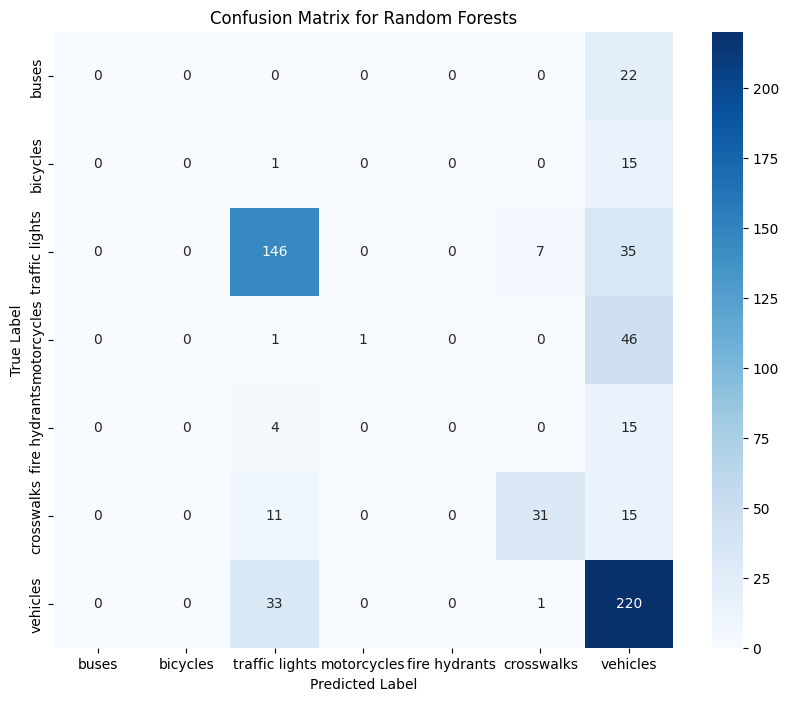

Random Forest model saved.
Visual vocabulary saved.


In [ ]:
# Prediction on the test set
y_pred = rf_classifier.predict(X_test)

# Calculate overall accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nModel Accuracy: {accuracy * 100:.2f}%")

# Detailed classification report
print("\n--- Detailed Classification Report ---")
target_names = list(class_names.values())
print(classification_report(y_test, y_pred, target_names=target_names))

# Create Confusion Matrix
conf_mat = confusion_matrix(y_test, y_pred)

# Visualize the Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(
    conf_mat,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=target_names,
    yticklabels=target_names
)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Random Forests')
plt.show()

# 5.1 Save Random Forest Classifier Model
joblib.dump(rf_classifier, 'random_forest_sift_model.joblib')
print("Random Forest model saved.")

# 5.2 Save Visual Vocabulary (You need this to convert any new image into a feature vector)
np.save('visual_vocabulary.npy', visual_vocabulary)
print("Visual vocabulary saved.")